# Deep Learning with PyTorch : Siamese Network

*Author: Eda AYDIN*

# Siamese Network

![siamese-network.png](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*bJABur9wzFNACosQkim8kw.png)

[Eng]

A Siamese Network is a type of neural network architecture that is used for tasks that involve finding similarities or differences between two input samples. The network consists of two identical subnetworks that share the same set of weights and are trained simultaneously.

The basic idea behind a Siamese Network is to learn a similarity metric between two input samples. In other words, the network is trained to output a high value when the two input samples are similar and a low value when they are dissimilar. This makes it useful for a variety of applications, such as image or text similarity matching, face recognition, and signature verification.

One of main advantages of a Siamese Network is that it can be trained with very few examples, making it useful for applications where data is limited. Additionally, the shared weights between the two subnetworks allow the model to generalize well to new inputs.

Siamese Networks have been shown to be effective in a wide range of applications, including image recognition, classification, and speech recognition. They have also been applied to natural language processing tasks such as sentence similarity and paraphrase detection.


[Tr]

Siamese Network, iki giriş örneği arasındaki benzerlik ve farklılıkları bulmak için kullanılan bir sinir ağı mimarisidir. Ağ, iki aynı alt ağdan oluşur ve her biri aynı ağırlık kümesini paylaşır.

Siamese Network'ün temel fikri, iki giriş örneği arasındaki benzerliği öğrenmektir. Bu nedenle, ağ, iki giriş örneği benzer olduğunda yüksek bir çıktı değeri verir ve farklı olduğunda ise düşük bir çıktı değeri verir. Bu, örneğin görüntü veya metin benzerliği eşleştirme, yüz tanıma veya imza doğrulama gibi birçok uygulama için kullanışlıdır.

Siamese Network'ü kullanmanın en büyük avantajı, sınırlı veriyle bile eğitilebilmesidir. Ayrıca, alt ağlar arasındaki ağırlık paylaşımı, modelin yeni girişlere iyi genelleme yapabilmesine olanak tanır.

Siamese Network, görüntü tanıma, sınıflandırma ve konuşma tanıma gibi birçok alanda etkili olduğu kanıtlanmıştır. Ayrıca, cümle benzerliği ve paraphrase tespiti gibi doğal dil işleme görevleri için de uygulanabilir.

# Download and Import libraries

In [31]:
!pip install segmentation-models-pytorch -q
!pip install -U git+https://github.com/albumentations-team/albumentations -q
!pip install --upgrade opencv-contrib-python -q


ERROR: Ignored the following versions that require a different python version: 0.0.18 Requires-Python >=3.9; 0.0.19 Requires-Python >=3.9; 0.0.20 Requires-Python >=3.9; 0.0.21 Requires-Python >=3.9; 0.0.22 Requires-Python >=3.9; 0.0.23 Requires-Python >=3.9
ERROR: Could not find a version that satisfies the requirement albucore==0.0.23 (from albumentations) (from versions: 0.0.1, 0.0.2, 0.0.3, 0.0.4, 0.0.5, 0.0.6, 0.0.7, 0.0.8, 0.0.9, 0.0.10, 0.0.11, 0.0.12, 0.0.13, 0.0.14, 0.0.15, 0.0.16, 0.0.17)
ERROR: No matching distribution found for albucore==0.0.23


In [32]:
!git clone https://github.com/parth1620/Person-Re-Id-Dataset

fatal: destination path 'Person-Re-Id-Dataset' already exists and is not an empty directory.


In [33]:
import sys
sys.path.append("Person-Re-Id-Dataset")

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch

"""
Timm: PyTorch Image Models (timm) is a library for state-of-the-art-image classification, containing a collection of image models, optimizers, schedulers, augmentations and much more.
"""
import timm

import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

"""
tqdm is a library that is used for creating Python Progress Bars. It gets its name from the Arabic name taqaddum, which means 'progress. '
"""
from tqdm import tqdm

# Configurations

In [35]:
DATA_DIR = "market-1501/versions/1/Market-1501-v15.09.15/bounding_box_train/"
CSV_FILE = "Person-Re-Id-Dataset/train.csv"

BATCH_SIZE = 32
LR = 0.001
EPOCHS = 15

DEVICE = 'cuda'

import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [36]:
df = pd.read_csv(CSV_FILE)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [37]:
row = df.iloc[11]

A_img = io.imread(DATA_DIR + row.Anchor)
P_img = io.imread(DATA_DIR + row.Positive)
N_img = io.imread(DATA_DIR + row.Negative)

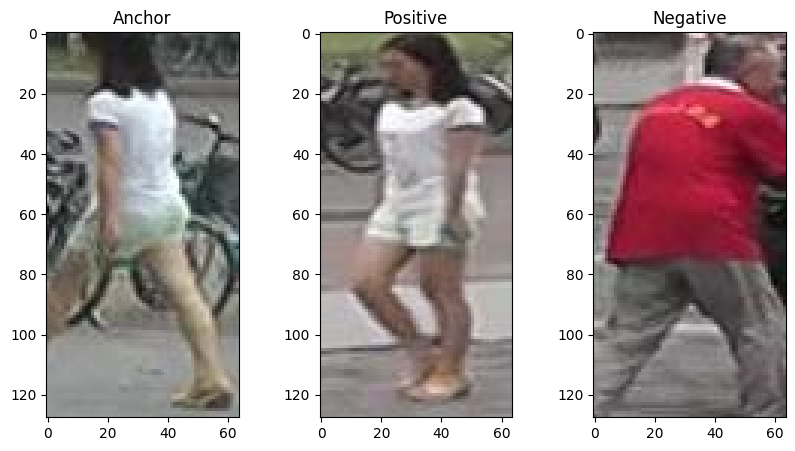

In [38]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (10,5))

ax1.set_title("Anchor")
ax1.imshow(A_img)

ax2.set_title("Positive")
ax2.imshow(P_img)

ax3.set_title("Negative")
ax3.imshow(N_img)

In [39]:
train_df, valid_df = train_test_split(df, test_size = 0.20, random_state = 42)

# Create APN Dataset

In [40]:
class APN_Dataset(Dataset):
    
    def __init__(self, df):
        self.df = df
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,idx):
        row = self.df.iloc[idx]
        
        A_img = io.imread(DATA_DIR + row.Anchor)
        P_img = io.imread(DATA_DIR + row.Positive)
        N_img = io.imread(DATA_DIR + row.Negative)
        
        A_img = torch.from_numpy(A_img).permute(2, 0 ,1) / 255.0
        P_img = torch.from_numpy(P_img).permute(2, 0 ,1) / 255.0
        N_img = torch.from_numpy(N_img).permute(2, 0 ,1) / 255.0
        
        return A_img, P_img, N_img
        

In [41]:
trainset = APN_Dataset(train_df)
validset = APN_Dataset(valid_df)

print(f"Size of trainset : {len(trainset)}")
print(f"Size of validset : {len(validset)}")

Size of trainset : 3200
Size of validset : 800


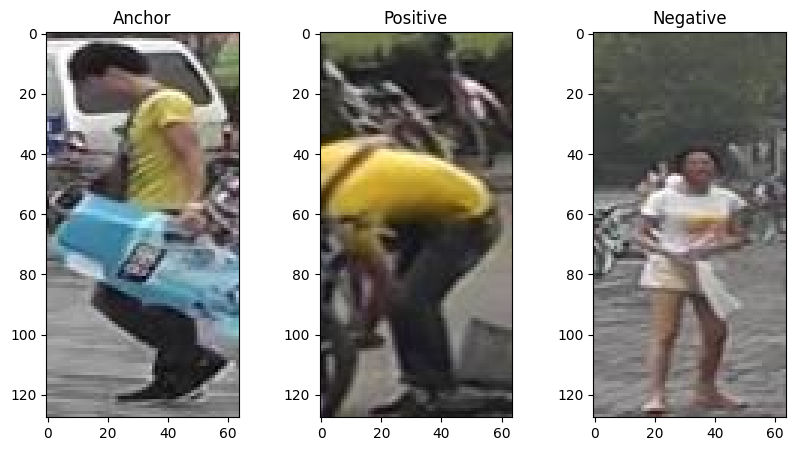

In [42]:
idx = 40
A,P,N = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(A.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(P.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(N.numpy().transpose((1,2,0)), cmap = 'gray')

# Load Dataset into Batches

In [43]:
trainloader = DataLoader(trainset, batch_size = BATCH_SIZE,shuffle = True)
validloader = DataLoader(validset, batch_size = BATCH_SIZE)

In [44]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [45]:
for A, P, N in trainloader:
    break;

print(f"One image batch shape : {A.shape}")

One image batch shape : torch.Size([32, 3, 128, 64])


# Create Model

In [46]:
class APN_Model(nn.Module):
    
    def __init__(self, emb_size = 512):
        super(APN_Model, self).__init__()
        
        self.efficientnet = timm.create_model('efficientnet_b0', pretrained=True)
        self.efficientnet.classifier = nn.Linear(in_features = self.efficientnet.classifier.in_features,
                                                out_features = emb_size)
        
    
    def forward(self, images):
        embeddings = self.efficientnet(images)
        return embeddings

In [47]:
model = APN_Model()
model.to(DEVICE)

APN_Model(
  (efficientnet): EfficientNet(
    (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNormAct2d(
      32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): DepthwiseSeparableConv(
          (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (bn1): BatchNormAct2d(
            32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (se): SqueezeExcite(
            (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (act1): SiLU(inplace=True)
            (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (gate): Sigmoid()
          )
          (conv_pw): Conv2d(32, 16, kernel_size

# Create Train and Eval Function

In [48]:
def train_fn(model, dataloader, optimizer, criterion):
    model.train() # ON Dropout
    total_loss = 0.0 
    
    for A,P,N in tqdm(dataloader):
        A,P,N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)
        
        A_embs = model(A)
        P_embs = model(P)
        N_embs = model(N)
        
        loss = criterion(A_embs, P_embs, N_embs)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        
    return total_loss / len(dataloader)

In [49]:
def eval_fn(model, dataloader, criterion):
    model.eval()  # OFF Dropout
    total_loss = 0.0 
    
    with torch.no_grad():
        for A,P,N in tqdm(dataloader):
            A,P,N = A.to(DEVICE), P.to(DEVICE), N.to(DEVICE)

            A_embs = model(A)
            P_embs = model(P)
            N_embs = model(N)

            loss = criterion(A_embs, P_embs, N_embs)

            total_loss += loss.item()
        
        return total_loss / len(dataloader)

In [50]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = LR)

# Create Training Loop

In [51]:
best_valid_loss = np.Inf

for i in range(EPOCHS):
    train_loss = train_fn(model, trainloader, optimizer, criterion)
    valid_loss = eval_fn(model, validloader, criterion)
    
    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), "best_model.pt")
        best_valid_loss = valid_loss
        print("SAVED_WEIGHT_SUCCESS")
    
    print(f"EPOCHS: {i+1} train_loss: {train_loss} valid_loss: {valid_loss}")

100%|██████████| 25/25 [00:11<00:00,  2.23it/s]


SAVED_WEIGHT_SUCCESS
EPOCHS: 1 train_loss: 0.6187573593854904 valid_loss: 0.5511082875728607


100%|██████████| 25/25 [00:06<00:00,  3.85it/s]


SAVED_WEIGHT_SUCCESS
EPOCHS: 2 train_loss: 0.2967247040569782 valid_loss: 0.28139142274856566


100%|██████████| 25/25 [00:06<00:00,  3.98it/s]


SAVED_WEIGHT_SUCCESS
EPOCHS: 3 train_loss: 0.14827725902199745 valid_loss: 0.2658802044391632


100%|██████████| 25/25 [00:05<00:00,  4.20it/s]


SAVED_WEIGHT_SUCCESS
EPOCHS: 4 train_loss: 0.11689917385578155 valid_loss: 0.16848714172840118


100%|██████████| 25/25 [00:06<00:00,  3.81it/s]


EPOCHS: 5 train_loss: 0.07025258257985115 valid_loss: 0.25627536594867706


100%|██████████| 25/25 [00:06<00:00,  4.10it/s]


EPOCHS: 6 train_loss: 0.10601662173867225 valid_loss: 0.18794812768697738


100%|██████████| 25/25 [00:05<00:00,  4.19it/s]


EPOCHS: 7 train_loss: 0.07888115897774696 valid_loss: 0.21883536726236344


100%|██████████| 25/25 [00:06<00:00,  4.13it/s]


EPOCHS: 8 train_loss: 0.055248450040817264 valid_loss: 0.272725550532341


100%|██████████| 25/25 [00:06<00:00,  3.97it/s]


SAVED_WEIGHT_SUCCESS
EPOCHS: 9 train_loss: 0.060645543485879895 valid_loss: 0.16275401532649994


100%|██████████| 25/25 [00:06<00:00,  3.96it/s]


SAVED_WEIGHT_SUCCESS
EPOCHS: 10 train_loss: 0.061604544967412946 valid_loss: 0.16167712092399597


100%|██████████| 25/25 [00:06<00:00,  3.99it/s]


SAVED_WEIGHT_SUCCESS
EPOCHS: 11 train_loss: 0.03580034345388412 valid_loss: 0.11723026394844055


100%|██████████| 25/25 [00:06<00:00,  3.97it/s]


EPOCHS: 12 train_loss: 0.02725811943411827 valid_loss: 0.12195304661989212


100%|██████████| 25/25 [00:07<00:00,  3.29it/s]


EPOCHS: 13 train_loss: 0.014701175540685653 valid_loss: 0.13809787690639497


100%|██████████| 25/25 [00:06<00:00,  3.79it/s]


SAVED_WEIGHT_SUCCESS
EPOCHS: 14 train_loss: 0.01344873234629631 valid_loss: 0.0936460867524147


100%|██████████| 25/25 [00:07<00:00,  3.48it/s]

EPOCHS: 15 train_loss: 0.025704821795225142 valid_loss: 0.13163299202919007


# Get Anchor Embeddings

In [52]:
def get_encoding_csv(model, anc_img_names):
    anc_img_names_arr = np.array(anc_img_names)
    encodings = []
    
    model.eval()
    with torch.no_grad():
        for i in tqdm(anc_img_names_arr):
            A = io.imread(DATA_DIR + i)
            A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
            A = A. to(DEVICE)
            A_enc = model(A.unsqueeze(0)) # c,h,w --> (1,c,h,w)
            encodings.append(A_enc.squeeze().cpu().detach().numpy())
        
        encodings = np.array(encodings)
        encodings = pd.DataFrame(encodings)
        df_enc = pd.concat([anc_img_names, encodings], axis=1)
    
    return df_enc

In [53]:
model.load_state_dict(torch.load("best_model.pt"))
df_enc = get_encoding_csv(model, df["Anchor"])

C:\Users\jokub\AppData\Local\Temp\ipykernel_37224\303838337.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))
100%|█████

In [54]:
df_enc.to_csv("database.csv", index=False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,-0.313026,0.490724,-0.059308,-0.757068,-0.872666,-0.460145,0.183782,-0.223353,-0.946364,...,0.369238,0.395826,-0.688365,-0.797282,-0.306950,0.396168,0.705917,-0.765384,-0.141784,-0.341157
1,1420_c3s3_061978_03.jpg,0.360555,-0.010106,-0.103634,-0.856060,-0.930948,0.168458,0.032294,-0.041585,-0.096613,...,0.047492,-0.018154,-0.915078,-1.014948,-0.036434,0.648901,-0.054941,-0.308602,0.340765,-0.500268
2,1420_c5s3_062565_05.jpg,-0.157435,0.318891,-0.200096,-0.678508,-0.775625,-0.078613,0.121059,-0.218428,-0.715858,...,0.240088,0.057362,-0.600542,-0.713416,-0.419183,0.574459,0.396591,-0.656859,0.162409,-0.142654
3,1420_c6s3_085592_04.jpg,0.308406,-0.147633,-0.050855,-0.582617,-0.020963,0.119474,0.236314,-0.382510,-0.640785,...,-0.083854,0.287044,-0.371863,-0.474492,-0.447138,0.458928,0.236019,-0.696300,-0.073071,-0.337640
4,0663_c5s3_085987_03.jpg,0.115752,-0.552575,0.565580,-0.176929,1.353867,-0.823519,0.196664,-0.977301,-1.497280,...,0.040285,0.926899,1.022967,0.143498,-0.065608,-0.163543,0.585972,-0.458181,-1.375410,-0.363914


# Inference

In [55]:
def euclidean_dist(img_enc, anc_enc_arr):
    dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc - anc_enc_arr).T))
    return dist

In [56]:
idx = 0
img_name = df_enc["Anchor"].iloc[idx]
img_path = DATA_DIR + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2, 0, 1) / 255.0

model.eval()
with torch.no_grad():
    img = img.to(DEVICE)
    img_enc = model(img.unsqueeze(0))
    img_enc = img_enc.detach().cpu().numpy()

In [57]:
anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
anc_img_names = df_enc["Anchor"]

In [58]:
distance = []

for i in range(anc_enc_arr.shape[0]):
    dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :])
    distance = np.append(distance, dist)

In [59]:
closest_idx = np.argsort(distance)

c:\Users\jokub\mambaforge\envs\tf\lib\site-packages\networkx\drawing\layout.py:726: RuntimeWarning: divide by zero encountered in divide
  costargs = (np, 1 / (dist_mtx + np.eye(dist_mtx.shape[0]) * 1e-3), meanwt, dim)


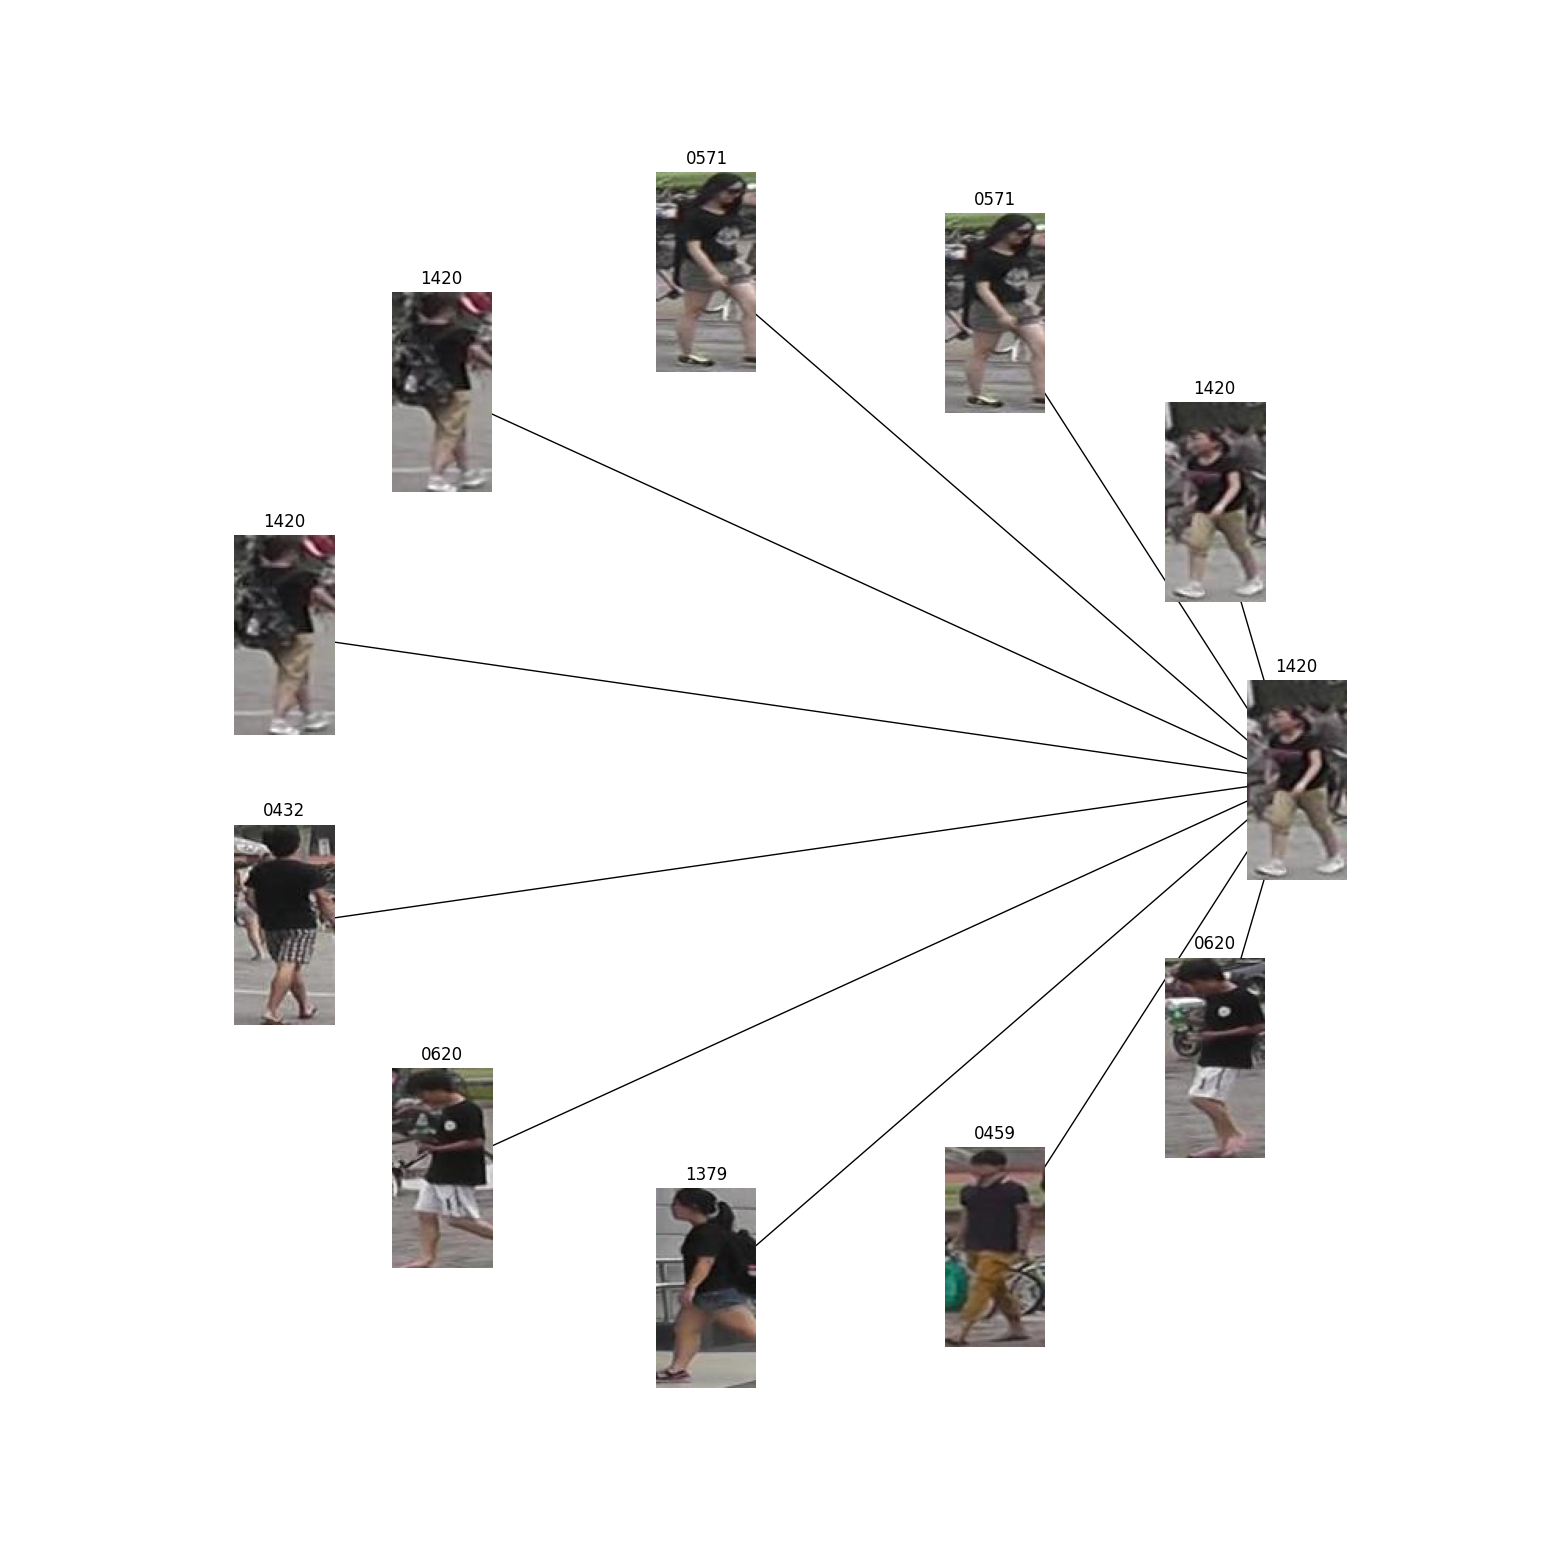

In [60]:
from utils import plot_closest_imgs

plot_closest_imgs(anc_img_names, DATA_DIR, img, img_path, closest_idx, distance, no_of_closest = 10);

# Resources

* [How to train your siamese neural network](https://towardsdatascience.com/how-to-train-your-siamese-neural-network-4c6da3259463)